###Install Packages and Import Data
To set up the environment, run the following two cells. Setting everything up may take a few moments.

Do not alter any of the code in the next two cells.

## Table of Contents: <a class="anchor" id="steps"></a>
- [1. Installation and Import of libraries](#install)
- [2. Importing Data](#data)
  - [2.1. Ad channels Data Split](#adchannel)
  - [2.2. Sales Data Pre Processing](#salespre)
  - [2.3. Spend Data Pre Processing](#spendpre)
  - [2.4. Spend Data Pre Processing](#clickpre)
  - [2.5. Create click data to fetch first touch attribution](#firsttouch)
- [3. Questions to Answer](#questions)
    - [3.1. What category of channel has the lowest cost per click?](#q1)
    - [3.2. What are the top three partnerships in terms of sales generated by first touch attribution?](#q2)
    - [3.3. Which campaigns had the most month-over-month percent growth/decline in sales generated from Oct to Dec?](#q3)
    - [3.4. Which partner is the most cost efficient, i.e., has the lowest CAC](#q4)
    - [3.5. Which category of channel has the best ROI? The worst?](#q5)
    - [3.6. On average, how many different channels do customers interact with prior to locking a car?](#q6)
    - [3.7. What percentage of sales don't have a click within 90 days prior to the conversion? How can you explain this?](#q7)
    - [3.8. Based on what you know about channel performance, what recommendation would you give for re-allocating spend given we are increasing budget by 20% next year?](#q8)
        - [3.8.1. Merging Sales and Spend data](#q81)
        - [3.8.2. Filtering Data to Oct,Nov,Dec Months of 2022](#q82)
        - [3.8.3. Sales By Category](#q83)
        - [3.8.4. Profit by category](#q84)
        - [3.8.5. Spend by Category](#q85)
        - [3.8.6. Merging KPIs- profit,sales, spend, CAC, ROI](#q86)
        - [3.8.7. ROI by Category Bar Plot](#q87)
        - [3.8.8. CAC by Category Bar Plot](#q88)
        - [3.8.9. Distribution of Sales by Category](#q89)
        - [3.8.10. Distribution of Spend by Category](#q810)
        - [3.8.11. Channel Breakdown by KPIs](#q811)
        - [3.8.12. Conclusion](#q812)
<hr>

## Installation and Importing the libraries <a class="anchor" id="install"></a>

> [Table of Contents](#steps)

In [1]:
%%capture
################################
#### do not alter this code ####
################################

!pip install pandas
!pip install jupysql
!pip install matplotlib

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## Importing Of Data <a class="anchor" id="data"></a>

> [Table of Contents](#steps)

In [2]:
%%capture

################################
#### do not alter this code ####
################################

ad_channel_path="data/ad_channels.csv"
clicks_path="data/clicks.csv"
locks_path="data/locks.csv"
sales_path="data/sales.csv"
spend_path="data/spend.csv"

ad_channels=pd.read_csv(ad_channel_path)
clicks=pd.read_csv(clicks_path)
locks=pd.read_csv(locks_path)
sales=pd.read_csv(sales_path)
spend=pd.read_csv(spend_path)

%load_ext sql
%sql sqlite://

%sql --persist ad_channels
%sql --persist clicks
%sql --persist locks
%sql --persist sales
%sql --persist spend

______________________________________________________
______________________________________________________


You can use SQL and/or python to answer any question. The environment has a jupysql to allow for running inline SQL. See example sql below.

Refer to the package documentation for more info on how to use: https://jupysql.ploomber.io/en/latest/api/configuration.html#style

Quick guide:
- single line sql: *%sql {sql query}*
- multi line sql: *%%sql
                  {sql query}*
- write output to object: *%% sql df_name << {sql query}*

## Pre Processing <a class="anchor" id="preprocess"></a>

> [Table of Contents](#steps)

### Ad_channels data splitting <a class="anchor" id="adchannel"></a>

> [Table of Contents](#steps)

In [3]:
ad_channels_split = ad_channels.copy()

# Split the column into two columns based on the hyphen
ad_channels_split[['category', 'partner_campaign']] = ad_channels['channel'].str.split('-', expand=True)

# Display the resulting DataFrame
ad_channels_split.head()

,channel_id,channel,category,partner_campaign
0,1,Search Engine-Hooli_Convertible,Search Engine,Hooli_Convertible
1,2,Search Engine-Hooli_Sedan,Search Engine,Hooli_Sedan
2,3,Search Engine-Hooli_Truck,Search Engine,Hooli_Truck
3,4,Search Engine-Bam_Convertible,Search Engine,Bam_Convertible
4,5,Search Engine-Bam_Sedan,Search Engine,Bam_Sedan


In [4]:
%load_ext sql
%sql sqlite://
    
%sql --persist ad_channels_split

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Running query in 'sqlite://'

Success! Persisted ad_channels_split to the database.

### Sales Data Pre processing <a class="anchor" id="salespre"></a>

> [Table of Contents](#steps)

In [5]:
sales2=sales.copy()

In [6]:
sales2['formatted_sale_date'] = pd.to_datetime(sales2['sale_datetime'], format='%Y-%m-%d %H:%M:%S')

In [7]:
sales2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              1348 non-null   int64         
 1   lock_id              1348 non-null   int64         
 2   sale_datetime        1348 non-null   object        
 3   sale_id              1348 non-null   int64         
 4   gross_profit         1348 non-null   float64       
 5   formatted_sale_date  1348 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 63.3+ KB


In [8]:
%load_ext sql
%sql sqlite://
    
%sql --persist sales2

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Running query in 'sqlite://'

Success! Persisted sales2 to the database.

In [9]:
%%sql

select * from sales2;

Running query in 'sqlite://'

index,user_id,lock_id,sale_datetime,sale_id,gross_profit,formatted_sale_date
0,38769,26334269,2022-10-29 00:16:17,1624686,65.26,2022-10-29 00:16:17.000000
1,99994,26423056,2022-11-11 13:11:27,1641936,-133.8,2022-11-11 13:11:27.000000
2,112497,26120673,2022-11-03 14:33:10,1628000,-30.0,2022-11-03 14:33:10.000000
3,135937,27526924,2022-12-22 21:26:51,1683483,-288.55,2022-12-22 21:26:51.000000
4,139005,26274535,2022-10-26 22:55:41,1624760,32.87,2022-10-26 22:55:41.000000
5,145988,25418426,2022-09-28 16:56:40,1592422,-240.84,2022-09-28 16:56:40.000000
6,164212,25057050,2022-09-14 17:32:46,1592597,844.72,2022-09-14 17:32:46.000000
7,215419,26356668,2022-10-30 13:58:18,1631982,909.96,2022-10-30 13:58:18.000000
8,317410,27189311,2022-12-04 06:36:01,1675258,-38.14,2022-12-04 06:36:01.000000
9,457643,25825636,2022-10-11 23:52:13,1608857,-48.77,2022-10-11 23:52:13.000000


### Spend Data Pre processing <a class="anchor" id="spendpre"></a>

> [Table of Contents](#steps)

In [10]:
spend2=spend.copy()

spend2['formatted_spend_date'] = pd.to_datetime(spend2['date'], format='%Y-%m-%d')

In [11]:
%%sql
select * from spend;

Running query in 'sqlite://'

index,channel_id,date,spend
0,1,2022-06-01,134.07
1,1,2022-06-02,45.11
2,1,2022-06-03,66.23
3,1,2022-06-04,28.03
4,1,2022-06-05,33.95
5,1,2022-06-06,89.28
6,1,2022-06-07,159.16
7,1,2022-06-08,11.44
8,1,2022-06-09,294.64
9,1,2022-06-10,18.18


In [12]:
spend2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   channel_id            3424 non-null   int64         
 1   date                  3424 non-null   object        
 2   spend                 3424 non-null   float64       
 3   formatted_spend_date  3424 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 107.1+ KB


In [13]:
%load_ext sql
%sql sqlite://
    
%sql --persist spend2

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Running query in 'sqlite://'

Success! Persisted spend2 to the database.

### Click Data Pre processing <a class="anchor" id="clickpre"></a>

> [Table of Contents](#steps)

In [14]:
# Assuming your DataFrame is named 'sales_dataframe' and the date-time column is 'sale_datetime'
clicks_updated=clicks.copy()
clicks_updated['formatted_click_date'] = pd.to_datetime(clicks_updated['click_datetime'], format="%Y-%m-%d %H:%M:%S.%f")


In [15]:
clicks_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168907 entries, 0 to 168906
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   click_datetime        168907 non-null  object        
 1   channel_id            168907 non-null  int64         
 2   user_id               168907 non-null  int64         
 3   formatted_click_date  168907 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.2+ MB


In [16]:
%load_ext sql
%sql sqlite://
    
%sql --persist clicks_updated

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Running query in 'sqlite://'

Success! Persisted clicks_updated to the database.

### Create first click data to fetch FIRST TOUCH ATRRIBUTION <a class="anchor" id="firsttouch"></a>

> [Table of Contents](#steps)

In [17]:
%%sql first_click_data <<
with first_click_data as(
select user_id,channel_id, channel ,category, partner_campaign from(
select user_id,c.channel_id, ac.channel ,ac.category, ac.partner_campaign,
rank() over (partition by user_id order by click_datetime asc) as rk
from clicks c
left join ad_channels_split ac on c.channel_id=ac.channel_id
) where rk=1)

select * from first_click_data;

Running query in 'sqlite://'

convert first_click_data to DF

In [18]:
first_click_channel= first_click_data.DataFrame()

In [19]:
first_click_channel.head()

,user_id,channel_id,channel,category,partner_campaign
0,10833,4,Search Engine-Bam_Convertible,Search Engine,Bam_Convertible
1,13887,13,Social Media-KnickKnack,Social Media,KnickKnack
2,13963,15,Third Party Listing-RealTruck,Third Party Listing,RealTruck
3,14696,2,Search Engine-Hooli_Sedan,Search Engine,Hooli_Sedan
4,15249,13,Social Media-KnickKnack,Social Media,KnickKnack


In [20]:
%load_ext sql
%sql sqlite://
    
%sql --persist first_click_channel

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Running query in 'sqlite://'

Success! Persisted first_click_channel to the database.

In [21]:
%%sql
select * from first_click_channel

Running query in 'sqlite://'

index,user_id,channel_id,channel,category,partner_campaign
0,10833,4,Search Engine-Bam_Convertible,Search Engine,Bam_Convertible
1,13887,13,Social Media-KnickKnack,Social Media,KnickKnack
2,13963,15,Third Party Listing-RealTruck,Third Party Listing,RealTruck
3,14696,2,Search Engine-Hooli_Sedan,Search Engine,Hooli_Sedan
4,15249,13,Social Media-KnickKnack,Social Media,KnickKnack
5,15957,2,Search Engine-Hooli_Sedan,Search Engine,Hooli_Sedan
6,19093,2,Search Engine-Hooli_Sedan,Search Engine,Hooli_Sedan
7,19327,3,Search Engine-Hooli_Truck,Search Engine,Hooli_Truck
8,19848,11,Finance Partnership-Debit Dharma,Finance Partnership,Debit Dharma
9,21272,16,Third Party Listing-ManualBarter,Third Party Listing,ManualBarter


## Questions to Answer: <a class="anchor" id="questions"></a>

> [Table of Contents](#steps)
### Performance & Economics

- What category of channel has the lowest cost per click?
- What are the top three partnerships in terms of sales generated by first touch attribution?
- Which campaigns had the most month-over-month percent growth/decline in sales generated from Oct to Dec?
- Which partner is the most cost efficient, i.e., has the lowest CAC
- Which category of channel has the best ROI? The worst?
### Incrementality

- On average, how many different channels do customers interact with prior to locking a car?
- What percentage of sales don't have a click within 90 days prior to the conversion? How can you explain this?
### Open Ended

- Based on what you know about channel performance, what recommendation would you give for re-allocating spend given we are inc easing budget by 

20% next year?

### 1.<u> What category of channel has the lowest cost per click? </u> <a class="anchor" id="q1"></a>

> [Table of Contents](#steps)

CPC= Spend/clicks

In [22]:
%%sql

with cte as(
select
category,
round(sum(spend)/count(click_datetime),2) as cpc,
rank() over (order by (sum(spend)/count(click_datetime)) asc) as rk
from ad_channels_split ac
left join spend s on ac.channel_id=s.channel_id
left join clicks c on ac.channel_id=c.channel_id
group by category
order by 2 asc)

 select category, cpc as min_cpc from cte where rk=1

Running query in 'sqlite://'

category,min_cpc
Online Video,56.97


Q1-Ans <b>Channel category - 'Online Video-WeTube_Teen' has the lowest cost per click of <span style="color:green">56.96</b>

### 2. <u>What are the top three partnerships in terms of sales generated by first touch attribution?</u> <a class="anchor" id="q2"></a>

> [Table of Contents](#steps)

In [23]:
%%sql
select partner_campaign as top_3_partner_campaigns,sales from(
select
case when partner_campaign is null then 'Others' else partner_campaign end as partner_campaign,
count(distinct sale_id) as sales,
dense_rank() over (order by count(distinct sale_id) desc) as rk
from 
sales2 s
left join first_click_channel fc 
on s.user_id=fc.user_id
group by partner_campaign
order by 2 desc)as temp
where rk<=3;

Running query in 'sqlite://'

top_3_partner_campaigns,sales
Hooli_Sedan,174
Debit Dharma,140
Hooli_Convertible,136


### 3. <u>Which campaigns had the most month-over-month percent growth/decline in sales generated from Oct to Dec?</u> <a class="anchor" id="q3"></a>

> [Table of Contents](#steps)

In [24]:
%%sql
with sales_partner_data as(
select 
ac.partner_campaign as partner_campaign,
strftime('%m-%Y', formatted_sale_date) as sales_month,
count(distinct s.sale_id) as current_month_sales,
coalesce(lag(count(distinct s.sale_id)) over (partition by ac.partner_campaign order by strftime('%m-%Y', formatted_sale_date)),0) as last_month_sales
from sales2 s
left join first_click_channel ac
on s.user_id=ac.user_id
where strftime('%Y', formatted_sale_date)<>'2023'
group by 1,2
order by 1,2)

, mom_sales_table as (select *,abs(current_month_sales-last_month_sales),
round(coalesce((cast(current_month_sales as float)-cast(last_month_sales as float) )/cast(last_month_sales as float),0)*100,2) as MOM_sales
from sales_partner_data
where partner_campaign is not null
order by coalesce((cast(current_month_sales as float)-cast(last_month_sales as float) )/cast(last_month_sales as float),0) desc
                        )

select partner_campaign,max(MOM_sales) as highest_mom_sales,sales_month from mom_sales_table order by mom_sales desc
;

Running query in 'sqlite://'

partner_campaign,highest_mom_sales,sales_month
ManualBarter,450.0,10-2022


### 4. <u>Which partner is the most cost efficient, i.e., has the lowest CAC </u> <a class="anchor" id="q4"></a>

> [Table of Contents](#steps)

CAC = Spend/Sales

In [25]:
%%sql

with sales_dt as(select strftime('%m-%Y', formatted_sale_date) as sales_month,
                 user_id,
                 count(distinct sale_id) as sales
                 from sales2 
                group by strftime('%m-%Y', formatted_sale_date) ,user_id)

, first_click_data as(
select user_id, channel_id from(
select *,
rank() over (partition by user_id order by formatted_click_date asc) as rk
from clicks_updated ) where rk=1)

, sales_channel AS(select sales_month,c.channel_id, sales
from sales_dt s
left join first_click_data c on s.user_id=c.user_id 
group by 1,2)

, spend_sales_channel as (select sc.*,s.monthly_spend as monthly_spend,
sales 
from sales_channel sc
inner join (select channel_id,strftime('%m-%Y', formatted_spend_date) as spend_month,
    sum(spend) as monthly_spend
    from
    spend2 
    group by 
        channel_id,
        strftime('%m-%Y', formatted_spend_date)) s on sc.channel_id=s.channel_id
and sc.sales_month=s.spend_month
         )

, cte1 as (select partner_campaign,
round(sum(coalesce(monthly_spend,0))/sum(sales),7) as cac,
dense_rank() over (order by (sum(coalesce(monthly_spend,0))/sum(sales)) asc) as cac_rk
from spend_sales_channel c
left join ad_channels_split ac 
on ac.channel_id=c.channel_id
group by partner_campaign
order by 2 asc)

select * from cte1 ;

Running query in 'sqlite://'

partner_campaign,cac,cac_rk
Datankle_Teen,678.93,1
WeTube_Teen,708.71,2
KnickKnack,1341.6566667,3
Bam_Truck,1721.3466667,4
Bam_Convertible,1729.5,5
WeTube_25+,1874.5575,6
Datankle_25+,2045.3075,7
Bam_Sedan,2391.5025,8
HeadLedger,2730.755,9
Giving Vine,2815.9625,10


### 5. <u>Which category of channel has the best ROI? The worst?</u> <a class="anchor" id="q5"></a>

> [Table of Contents](#steps)

ROI = Profit/Spend

In [26]:
%%sql
with sales_dt as(select 
                 strftime('%m-%Y', formatted_sale_date) as sales_month,
                 user_id,
                 sum(gross_profit) as profit
                 from sales2 
                group by  strftime('%m-%Y', formatted_sale_date),user_id)

, first_click_data as(
select user_id, channel_id from(
select *,
rank() over (partition by user_id order by formatted_click_date asc) as rk
from clicks_updated ) where rk=1)

, sales_channel AS(select sales_month,c.channel_id,sum(s.profit) as monthly_profit
from sales_dt s
left join first_click_data c on s.user_id=c.user_id 
group by 1,2)

, cte as (select sc.*,s.monthly_spend as monthly_spend
from sales_channel sc
inner join (
    select channel_id,strftime('%m-%Y', formatted_spend_date) as spend_month,
    sum(spend) as monthly_spend
    from
    spend2 
    group by 
        channel_id,
        strftime('%m-%Y', formatted_spend_date)) s 
on sc.channel_id=s.channel_id
and sc.sales_month=s.spend_month
         )

select category, 
round(sum(monthly_profit),2) as profit_by_category,
round(sum(monthly_spend ),2) as spend_by_category,
round(sum(monthly_profit)/sum(monthly_spend),2) as ROI
from cte
left join ad_channels_split ac on cte.channel_id=ac.channel_id
group by category 
order by round(sum(monthly_profit)/sum(monthly_spend),2) desc;

Running query in 'sqlite://'

category,profit_by_category,spend_by_category,ROI
Finance Partnership,151040.02,23555.35,6.41
Search Engine,224354.48,62470.23,3.59
Social Media,47800.0,14947.99,3.2
Online Video,32344.97,17067.1,1.9
Third Party Listing,-6152.3,34140.96,-0.18


Third Party Listing has worst ROI of -0.18 while Finance Partnership category has the best ROI of 6.41

### 6. <u>On average, how many different channels do customers interact with prior to locking a car?</u> <a class="anchor" id="q6"></a>

> [Table of Contents](#steps)

In [27]:
%%sql
select 
round(cast(sum(n_channels) as float)/cast(count(user_id) as float),0) as avg_interaction_before_lock
from(
select
c.user_id,
count(distinct channel_id) as n_channels
from 
locks l
left join clicks c on c.user_id=l.user_id
where click_datetime<lock_datetime
group by 1)tmp;

Running query in 'sqlite://'

avg_interaction_before_lock
4.0


### 7. <u>What percentage of sales don't have a click within 90 days prior to the conversion? How can you explain this?</u> <a class="anchor" id="q7"></a>

> [Table of Contents](#steps)

In [28]:
%%sql
with cte as (select 
    a.user_id as user_id,formatted_sale_date,
    max(b.formatted_click_date) as latest_click_date
from sales2 a
left join clicks_updated b
on a.user_id = b.user_id
and 
formatted_click_date<=a.formatted_sale_date
 group by a.user_id,formatted_sale_date)


select 
round((cast(sum(case when (julianday(formatted_sale_date)-julianday(latest_click_date))>=90 then 1 else 0 end) as float)/cast(count(*) as float))*100,2) as perc_with_no_click_within_90days_conversion
from(
select user_id,latest_click_date,formatted_sale_date
,julianday(formatted_sale_date) - julianday(latest_click_date) AS date_difference
from cte)tmp
;

Running query in 'sqlite://'

perc_with_no_click_within_90days_conversion
0.82


### 8. <u>Based on what you know about channel performance, what recommendation would you give for re-allocating spend given we are increasing budget by 20% next year?</u> <a class="anchor" id="q8"></a>

> [Table of Contents](#steps)

#### 8.1. <u>Merging Sales and Spend data</u> <a class="anchor" id="q81"></a>

> [Table of Contents](#steps)

In [29]:
%%sql sales_by_channel << WITH first_click_data AS(
SELECT user_id, channel_id FROM(
SELECT *,
rank() over (partition by user_id order by click_datetime asc) AS rk
FROM clicks_updated ) where rk=1)


, cte AS(
SELECT sale_id,gross_profit,formatted_sale_date AS sales_date,
channel ,category, partner_campaign,
'sales' AS table_flag
FROM sales2 s
left join first_click_data c 
on s.user_id=c.user_id
left join ad_channels_split ac 
on ac.channel_id=c.channel_id
order by formatted_sale_date desc)

SELECT * FROM cte ;

Running query in 'sqlite://'

In [30]:
sales_by_channel= sales_by_channel.DataFrame()

In [31]:
%load_ext sql
%sql sqlite://
    
%sql --persist sales_by_channel

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Running query in 'sqlite://'

Success! Persisted sales_by_channel to the database.

In [32]:
%%sql
select * from sales_by_channel;

Running query in 'sqlite://'

index,sale_id,gross_profit,sales_date,channel,category,partner_campaign,table_flag
0,1803778,-97.74,2023-04-23 19:40:36.000000,Third Party Listing-ManualBarter,Third Party Listing,ManualBarter,sales
1,1693857,615.45,2023-01-05 19:28:26.000000,Search Engine-Hooli_Truck,Search Engine,Hooli_Truck,sales
2,1688300,2030.02,2022-12-29 21:55:08.000000,Finance Partnership-Debit Dharma,Finance Partnership,Debit Dharma,sales
3,1688298,979.38,2022-12-29 21:13:02.000000,Search Engine-Hooli_Convertible,Search Engine,Hooli_Convertible,sales
4,1688292,774.86,2022-12-29 12:45:21.000000,Finance Partnership-Giving Vine,Finance Partnership,Giving Vine,sales
5,1688284,688.68,2022-12-28 20:17:09.000000,Search Engine-Hooli_Convertible,Search Engine,Hooli_Convertible,sales
6,1689136,926.13,2022-12-28 19:28:16.000000,Search Engine-Hooli_Convertible,Search Engine,Hooli_Convertible,sales
7,1688278,-35.61,2022-12-28 18:56:50.000000,Third Party Listing-RealTruck,Third Party Listing,RealTruck,sales
8,1688274,128.68,2022-12-28 17:47:25.000000,Search Engine-Hooli_Sedan,Search Engine,Hooli_Sedan,sales
9,1688262,625.7,2022-12-28 14:40:18.000000,Search Engine-Hooli_Truck,Search Engine,Hooli_Truck,sales


In [33]:
%%sql sales_spend_data_merge <<
with spend_by_channel as(
    select s.*,ac.channel,
ac.category,
ac.partner_campaign
from
spend2 s
left join ad_channels_split ac on
s.channel_id=ac.channel_id)

select 
sale_id
,gross_profit
,sales_date as date
,channel 
,category
, partner_campaign
,0 as spend
,table_flag
from sales_by_channel
union all
select
null as sale_id,
0 as gross_profit,
formatted_spend_date as date,
channel,
category,
partner_campaign,
spend,
'spend' as table_flag
from spend_by_channel;

Running query in 'sqlite://'

In [34]:
sales_spend_data_merge_df= sales_spend_data_merge.DataFrame()

In [35]:
%load_ext sql
%sql sqlite://
    
%sql --persist sales_spend_data_merge_df

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Running query in 'sqlite://'

Success! Persisted sales_spend_data_merge_df to the database.

In [36]:
sales_spend_data_merge_df.to_csv("sales_spend_data_merge.csv",index="False")

In [37]:
df=sales_spend_data_merge_df.copy()

In [38]:
sales_spend_data_merge_df.head()

,sale_id,gross_profit,date,channel,category,partner_campaign,spend,table_flag
0,1803778.0,-97.74,2023-04-23 19:40:36.000000,Third Party Listing-ManualBarter,Third Party Listing,ManualBarter,0.0,sales
1,1693857.0,615.45,2023-01-05 19:28:26.000000,Search Engine-Hooli_Truck,Search Engine,Hooli_Truck,0.0,sales
2,1688300.0,2030.02,2022-12-29 21:55:08.000000,Finance Partnership-Debit Dharma,Finance Partnership,Debit Dharma,0.0,sales
3,1688298.0,979.38,2022-12-29 21:13:02.000000,Search Engine-Hooli_Convertible,Search Engine,Hooli_Convertible,0.0,sales
4,1688292.0,774.86,2022-12-29 12:45:21.000000,Finance Partnership-Giving Vine,Finance Partnership,Giving Vine,0.0,sales


#### 8.2. <u>Filtering data to October, November, December</u> <a class="anchor" id="q82"></a>

> [Table of Contents](#steps)

In [39]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [40]:
# Filter the DataFrame to include only rows with dates in October, November, and December
df_filtered = df[(df['date'].dt.month >= 10) & (df['date'].dt.month <= 12)].copy()

df_filtered.reset_index(inplace=True)

df_filtered.drop('index',axis=1,inplace=True)
# Display the filtered DataFrame
display(df_filtered)

,sale_id,gross_profit,date,channel,category,partner_campaign,spend,table_flag
0,1688300.0,2030.02,2022-12-29 21:55:08,Finance Partnership-Debit Dharma,Finance Partnership,Debit Dharma,0.00,sales
1,1688298.0,979.38,2022-12-29 21:13:02,Search Engine-Hooli_Convertible,Search Engine,Hooli_Convertible,0.00,sales
2,1688292.0,774.86,2022-12-29 12:45:21,Finance Partnership-Giving Vine,Finance Partnership,Giving Vine,0.00,sales
3,1688284.0,688.68,2022-12-28 20:17:09,Search Engine-Hooli_Convertible,Search Engine,Hooli_Convertible,0.00,sales
4,1689136.0,926.13,2022-12-28 19:28:16,Search Engine-Hooli_Convertible,Search Engine,Hooli_Convertible,0.00,sales
...,...,...,...,...,...,...,...,...
2476,NaN,0.00,2022-12-27 00:00:00,Third Party Listing-ManualBarter,Third Party Listing,ManualBarter,270.00,spend
2477,NaN,0.00,2022-12-28 00:00:00,Third Party Listing-ManualBarter,Third Party Listing,ManualBarter,260.93,spend
2478,NaN,0.00,2022-12-29 00:00:00,Third Party Listing-ManualBarter,Third Party Listing,ManualBarter,663.61,spend
2479,NaN,0.00,2022-12-30 00:00:00,Third Party Listing-ManualBarter,Third Party Listing,ManualBarter,0.26,spend


In [41]:
# Filter the DataFrame to include only rows with sales (table_flag == 'sales')
df_sales = df_filtered[df_filtered['table_flag'] == 'sales']

In [42]:
# Group by 'category' and count distinct 'sale_id'
category_counts = df_sales.groupby('category')['sale_id'].nunique()
df_category_counts = category_counts.reset_index(name='sales')

In [43]:
df_category_counts

,category,sales
0,Finance Partnership,173
1,Online Video,165
2,Search Engine,414
3,Social Media,124
4,Third Party Listing,125


#### 8.3. <u>Sales By Category</u> <a class="anchor" id="q83"></a>

> [Table of Contents](#steps)

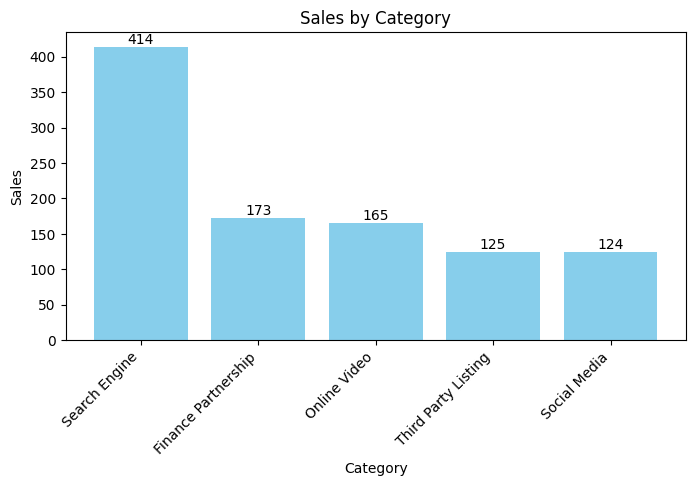

In [44]:
# Group by 'category' and count distinct 'sale_id'
category_counts = df_sales.groupby('category')['sale_id'].nunique()

# Sort by descending order
category_counts = category_counts.sort_values(ascending=False)

# Plot a bar chart with value labels
plt.figure(figsize=(8, 4))
bars = plt.bar(category_counts.index, category_counts, color='skyblue')

# Plot a bar chart
plt.xlabel('Category')
plt.ylabel('Sales')
plt.title('Sales by Category')

# Adding value labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [45]:
# create data frame for sales by category
category_counts = category_counts.sort_values(ascending=False)
category_counts_df=pd.DataFrame(category_counts)
category_counts_df.reset_index(inplace=True)

category_counts_df.rename(columns={'sale_id': 'sales'}, inplace=True)
category_counts_df

,category,sales
0,Search Engine,414
1,Finance Partnership,173
2,Online Video,165
3,Third Party Listing,125
4,Social Media,124


#### 8.4. <u>Profit by category</u> <a class="anchor" id="q84"></a>

> [Table of Contents](#steps)

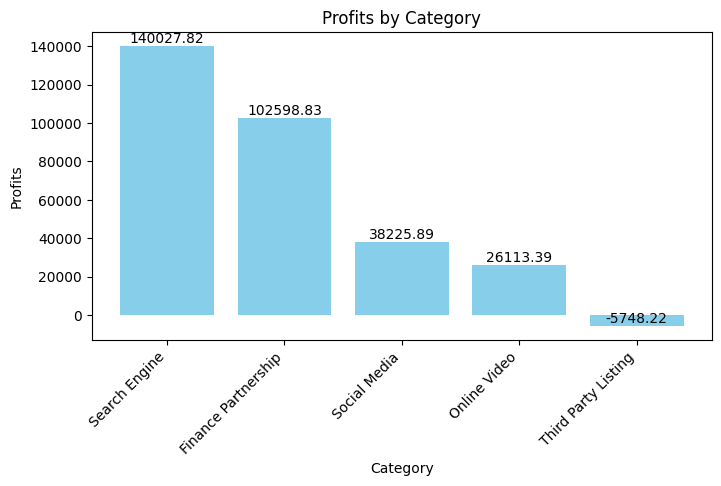

In [46]:
# Group by 'category' and sum of 'profit'
category_profits = df_sales.groupby('category')['gross_profit'].sum()

# Sort by descending order
category_profits = category_profits.sort_values(ascending=False)

# Plot a bar chart with value labels
plt.figure(figsize=(8, 4))
bars = plt.bar(category_profits.index, category_profits, color='skyblue')

plt.xlabel('Category')
plt.ylabel('Profits')
plt.title('Profits by Category')

# Adding value labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [47]:
# create data frame for profit by category
category_profits = category_profits.sort_values(ascending=False)
category_profits_df=pd.DataFrame(category_profits)
category_profits_df.reset_index(inplace=True)

category_profits_df.rename(columns={'gross_profit': 'profit'}, inplace=True)
category_profits_df

,category,profit
0,Search Engine,140027.82
1,Finance Partnership,102598.83
2,Social Media,38225.89
3,Online Video,26113.39
4,Third Party Listing,-5748.22


#### 8.5. <u>Spend by Category</u> <a class="anchor" id="q85"></a>

> [Table of Contents](#steps)

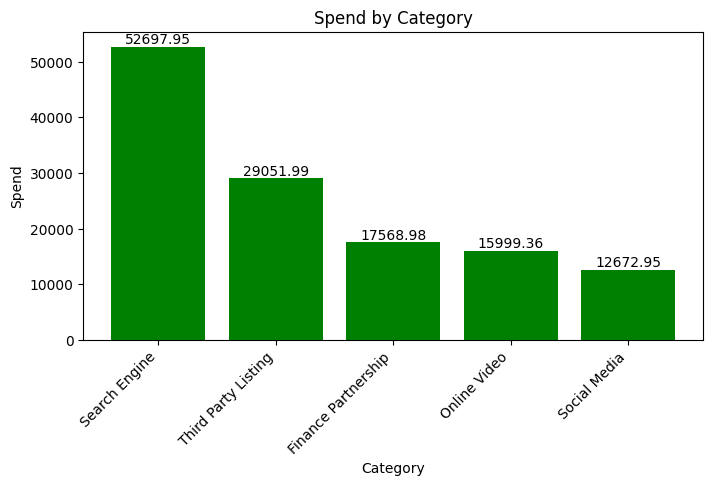

In [48]:
# Group by 'category' and sum of 'profit'
category_spend = df_filtered.groupby('category')['spend'].sum()

# Sort by descending order
category_spend = category_spend.sort_values(ascending=False)

# Plot a bar chart with value labels
plt.figure(figsize=(8, 4))
bars = plt.bar(category_spend.index, category_spend, color='green')

plt.xlabel('Category')
plt.ylabel('Spend')
plt.title('Spend by Category')

# Adding value labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [49]:
# create data frame for spend by category
category_spend = category_spend.sort_values(ascending=False)
category_spend_df=pd.DataFrame(category_spend)
category_spend_df.reset_index(inplace=True)

category_spend_df

,category,spend
0,Search Engine,52697.95
1,Third Party Listing,29051.99
2,Finance Partnership,17568.98
3,Online Video,15999.36
4,Social Media,12672.95


#### 8.6. <u>Merging KPIs- profit,sales, spend, CAC, ROI</u> <a class="anchor" id="q86"></a>

> [Table of Contents](#steps)

In [50]:
df_merged_profit_sales_by_category= pd.merge(category_counts_df,category_profits_df,on="category",how="left")
df_merged_profit_sales_by_category

,category,sales,profit
0,Search Engine,414,140027.82
1,Finance Partnership,173,102598.83
2,Online Video,165,26113.39
3,Third Party Listing,125,-5748.22
4,Social Media,124,38225.89


In [51]:
df_merged_kpis_by_category= pd.merge(df_merged_profit_sales_by_category,category_spend_df,on="category",how="left")

display(df_merged_kpis_by_category)

,category,sales,profit,spend
0,Search Engine,414,140027.82,52697.95
1,Finance Partnership,173,102598.83,17568.98
2,Online Video,165,26113.39,15999.36
3,Third Party Listing,125,-5748.22,29051.99
4,Social Media,124,38225.89,12672.95


In [52]:
df_merged_kpis_by_category['ROI']= df_merged_kpis_by_category['profit']/df_merged_kpis_by_category['spend']
df_merged_kpis_by_category['CAC']=df_merged_kpis_by_category['spend']/df_merged_kpis_by_category['sales']
df_merged_kpis_by_category

,category,sales,profit,spend,ROI,CAC
0,Search Engine,414,140027.82,52697.95,2.657178,127.289734
1,Finance Partnership,173,102598.83,17568.98,5.839772,101.554798
2,Online Video,165,26113.39,15999.36,1.632152,96.965818
3,Third Party Listing,125,-5748.22,29051.99,-0.197860,232.415920
4,Social Media,124,38225.89,12672.95,3.016337,102.201210


#### 8.7. <u>ROI by Category Bar Plot</u> <a class="anchor" id="q87"></a>

> [Table of Contents](#steps)

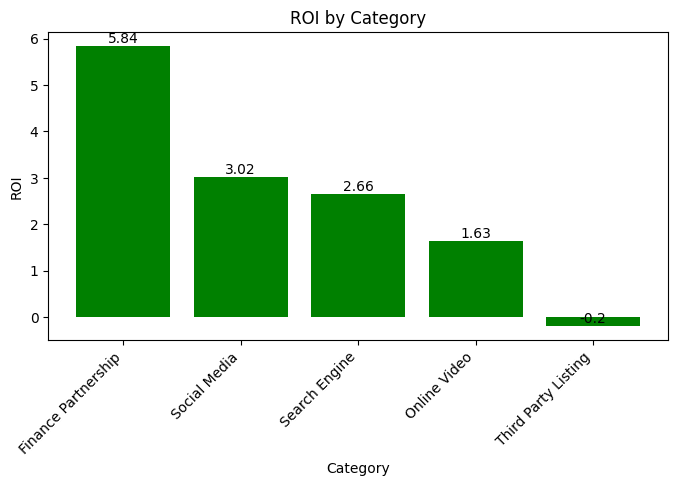

In [53]:
# Plot a bar chart with value labels
# Sort the DataFrame by 'ROI' in descending order
df_merged_kpis_by_category = df_merged_kpis_by_category.sort_values(by='ROI', ascending=False)

plt.figure(figsize=(8, 4))
bars = plt.bar(df_merged_kpis_by_category['category'], df_merged_kpis_by_category['ROI'], color='green')

plt.xlabel('Category')
plt.ylabel('ROI')
plt.title('ROI by Category')

# Adding value labels to the bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

#### 8.8. <u>CAC by Category Bar Plot</u> <a class="anchor" id="q88"></a>

> [Table of Contents](#steps)

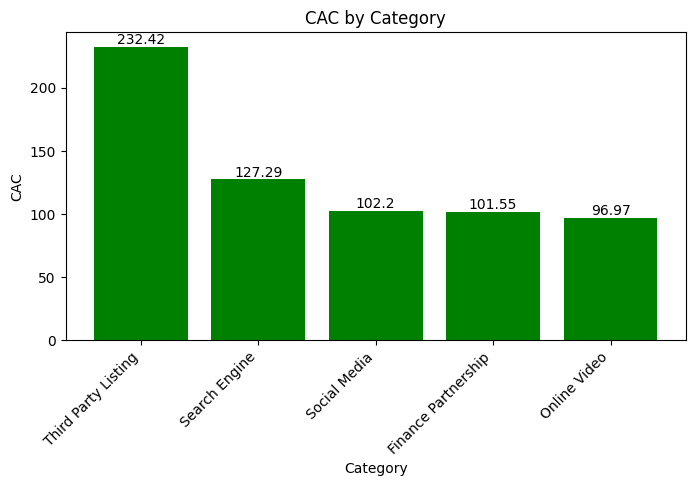

In [54]:
# Plot a bar chart with value labels
# Sort the DataFrame by 'CAC' in descending order
df_merged_kpis_by_category = df_merged_kpis_by_category.sort_values(by='CAC', ascending=False)

plt.figure(figsize=(8, 4))
bars = plt.bar(df_merged_kpis_by_category['category'], df_merged_kpis_by_category['CAC'], color='green')

plt.xlabel('Category')
plt.ylabel('CAC')
plt.title('CAC by Category')

# Adding value labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

#### 8.9. <u>Distribution of Sales by Category</u> <a class="anchor" id="q89"></a>

> [Table of Contents](#steps)

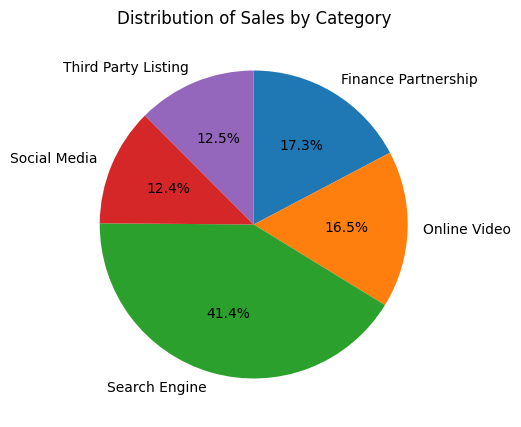

In [55]:
# Sort the DataFrame by 'Sales' in descending order
df_sorted = df_merged_kpis_by_category.sort_values(by='sales', ascending=False)

# Calculate the total sales for each category
sales_dist = df_sorted.groupby('category')['sales'].sum()

# Plot a pie chart
plt.figure(figsize=(5, 5))
plt.pie(sales_dist, labels=sales_dist.index, autopct='%1.1f%%', startangle=90, counterclock=False)

plt.title('Distribution of Sales by Category')
plt.show()

#### 8.9. <u>Distribution of Spend by Category</u> <a class="anchor" id="q810"></a>

> [Table of Contents](#steps)

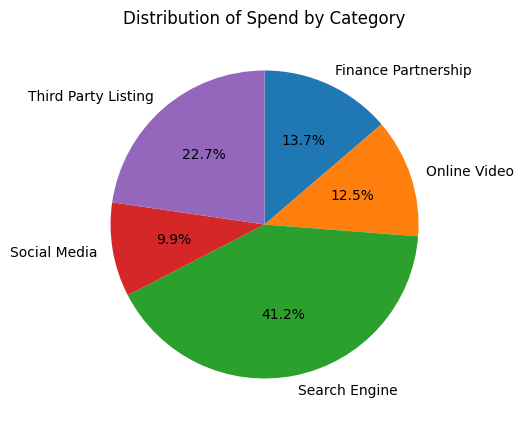

In [56]:
# Sort the DataFrame by 'Spend' in descending order
df_sorted = df_merged_kpis_by_category.sort_values(by='spend', ascending=False)

# Calculate the total spend for each category
spend_dist = df_sorted.groupby('category')['spend'].sum()

# Plot a pie chart
plt.figure(figsize=(5, 5))
plt.pie(spend_dist, labels=spend_dist.index, autopct='%1.1f%%', startangle=90, counterclock=False)

plt.title('Distribution of Spend by Category')
plt.show()

#### 8.11. <u>Channel Breakdown by KPIs</u> <a class="anchor" id="q811"></a>

> [Table of Contents](#steps)

In [57]:
# Create a new column 'sales_flag' with a value of 1 for non-null 'sale_id', and 0 otherwise
df_filtered['sales_flag'] = df_filtered['sale_id'].notnull().astype(int)

# Group by 'category' and 'partner_campaign' for kpis
category_channel_kpis = df_filtered.groupby(['category','partner_campaign'])[['spend','gross_profit','sales_flag']].sum()
# Sort by descending order
category_channel_kpis=category_channel_kpis.rename(columns={'sales_flag':'sales','gross_profit':'profit'})

category_channel_kpis['ROI']= category_channel_kpis['profit']/category_channel_kpis['spend']
category_channel_kpis['CAC']=category_channel_kpis['spend']/category_channel_kpis['sales']

# Define a function to highlight the top 3 and bottom 2 values
def highlight_values(val):
    top3_values = category_channel_kpis.head(3)
    bottom2_values = category_channel_kpis.tail(2)
    
    # Check if the value is in the top 3 values of 'spend', 'profit', or 'sales'
    if val in top3_values['spend'].values or val in top3_values['profit'].values or val in top3_values['sales'].values or val in top3_values['ROI'].values or val in top3_values['CAC'].values:
        return 'background-color: lightgreen'
    # Check if the value is in the bottom 2 values of 'spend', 'profit', or 'sales'
    elif val in bottom2_values['spend'].values or val in bottom2_values['profit'].values or val in bottom2_values['sales'].values or val in bottom2_values['ROI'].values or val in bottom2_values['CAC'].values:
        return 'background-color: lightcoral'
    else:
        return ''

# Apply the styling function to the DataFrame
top_bottom_kpis_df = category_channel_kpis.style.applymap(highlight_values)

# Display the styled DataFrame
top_bottom_kpis_df

/tmp/ipykernel_14417/80288950.py:27: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  top_bottom_kpis_df = category_channel_kpis.style.applymap(highlight_values)


#### 8.12. <u>Conclusion</u> <a class="anchor" id="q812"></a>

> [Table of Contents](#steps)

1. **Finance Partnership:**
   - **Debit Dharma:** This campaign has a high ROI of 5.42 and a positive profitability of 49,483 USD. With a CAC of 97.09 USD, it shows efficient use of marketing spend. Consider allocating more budget to capitalize on its strong performance.
   - **Giving Vine:** Another strong performer with a high ROI of 6.29 and positive profitability of 53,115.78 USD. The CAC is 106.86 USD, indicating efficient customer acquisition. Allocate more budget to maximize returns.

   - <span style="color:Green"> <b>Finance partner channels have the highest ROI of 6.41 and their CAC is lowest among all categories. Their sales and profit values are the secong highest while their spend is 3rd highest indicating positive correlation between spend and profits.</b>

2. **Online Video:**
   - **Datankle_25+:** With a decent ROI of 1.82 and positive profitability of $11,031.20, this campaign represents a balanced performance. Consider maintaining or slightly increasing budget allocation.

3. **Third Party Listing:**
   - **ManualBarter:** This campaign has a negative profitability and ROI, suggesting a re-evaluation of its effectiveness. Consider reducing or re-allocating budget to more successful campaigns.
   - <span style="color:Red"> <b>Third party Listing has high cost [67K] accounting to 23% of overall cost and has negative gross profits along with least sales [130 i.e. less than 10% of overall sales] as compared to others.</b>
   - <span style="color:Red"> <b>The cost to acquire customers for 3rd party listing channels is very high[3 times more than other categories] with a negative return on investment of -0.18.</b>
   - <span style="color:Red"> <b>Hence for next year, the company should strategically invest less in 3rd party channels or completely eliminate the channel.</b>

4. **Search Engine Channels:**
   - **Bam_Convertible, Bam_Sedan, Bam_Truck:** These campaigns demonstrate positive profitability and reasonable ROIs. Consider maintaining or slightly increasing budget allocation.
   - **Hooli Channels (Convertible, Sedan, Truck):** <b><span style="color:Green">These channels show positive profitability and ROI, suggesting efficient use of spend. Consider maintaining or slightly increasing budget allocation.</b>

5. **Social Media Channels:**
   - **KnickKnack:** With a positive ROI of 3.88 and profitability of 15,599.98 USD, consider maintaining or increasing budget allocation.
   - **HeadLedger:** With a positive ROI of 2.62 and profitability of 22,625.91 USD, this campaign shows promise. Consider maintaining or increasing budget based on budget based on strategic objectives.

<span style="color:Green">Overall, prioritize Finance partnership channels <b>Debit Dharma and Giving Vine</b> since they have the highest ROI, profit, and sales. Their CAC as a category is also the lowest among other categories. which is efficient.

<span style="color:Green">Search Engine channels such as Bam and Hooli also have good ROI, profit and sales. Hooli channels have more sales as compared to BAM channels, we can increase budget to increase sales for BAM channels and promote Hooli channels even more for the performance growth next year.

<span style="color:Green">Online channels such as Dat_Ankle_25+ and WeTube_25+ have good ROI and promising sales. Their profits are also good and CAC is also low. Hence the company can invest in these online channels  for performance growth.

<span style="color:Red">Reallocate budget from underperforming campaigns i.e. Third Party Listing - ManualBarter and Reat Truck channels to those with proven success. These channels incurred losses with a negative ROI of -0.18 and have considerably high spend/cost[23% of overall budget] and their CAC is also very high [3 times more than other categories]. Hence, for next year, we should not be investing in these channels or change our strategies.

At last, we should regularly monitor performance metrics to adapt strategies and maximize the impact of the increased budget.